In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from wordcloud import WordCloud
from konlpy.tag import Twitter
from collections import Counter
from nltk.probability import FreqDist
from sklearn.preprocessing import QuantileTransformer


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import time
import warnings
warnings.filterwarnings("ignore")

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 14

In [73]:
# import scipy.sparse as spr

---
# 데이터 불러오기

In [74]:
# train (playlist)
train = pd.read_json('data/train.json')

#genre
genre_gn_all = pd.read_json('data/genre_gn_all.json', typ='series')
genre_gn_all = pd.DataFrame(genre_gn_all, columns = ['gnr_name']).reset_index().rename(columns = {'index' : 'gnr_code'})

# songs
song_meta = pd.read_json('data/song_meta.json')

# plylst 별 tag 유사도를 살펴보자


> - 1) `train`, `train['tags']` 확인   
> - 2) `train['tags']` [ ] 제거
> - 3) plylst 좋아요 5개 이상 받은 plylst의 태그 선별 (11만 개 -> 3만3천개)
> - 4) Tfidf Vectorizing 사용

## 전처리
데이터 내부엔 list(dict()) 형태로 구성되어 있습니다. 또한 이 안에는 **문자열** 형태로 들어가있구요.  
이를 처리하기 위해서 ast의 literal_eval 함수를 사용했습니다.   

>개인공부   
> `AST 모듈`은 문법을 구조화 시켜주는 모듈    
python 에서 제공하는 기본 type 정도만 변환해주는 용도로 사용 가능   
`literal_eval`은 python 의 기본 자료형 정도만 evaluate 가 가능하도록 지원한다. eval 과 비교해 훨씬 엄격   
그 사용 용도가 eval 대비 훨씬 제한적     
literal_eval 의 용도 :  string을 자료형으로 구조화 시키는 것.

> `apply 함수` :    
numpy의 단일함수를 호출 시 axis=0, 1의 결과값이 같음.   
numpy의 집계함수를 호출 시 axis=0 (행), axis=1 (열)

> `lambda x 함수` : 

In [4]:
# train 정보 확인.
train.info()
train.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115071 entries, 0 to 115070
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   tags          115071 non-null  object
 1   id            115071 non-null  int64 
 2   plylst_title  115071 non-null  object
 3   songs         115071 non-null  object
 4   like_cnt      115071 non-null  int64 
 5   updt_date     115071 non-null  object
dtypes: int64(2), object(4)
memory usage: 5.3+ MB


,tags,id,plylst_title,songs,like_cnt,updt_date
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000


In [5]:
# train tags 값 확인
train['tags']

0                                                       [락]
1                                                  [추억, 회상]
2                                                 [까페, 잔잔한]
3         [연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...
4                                                      [댄스]
                                ...                        
115066                 [록메탈, 밴드사운드, 록, 락메탈, 메탈, 락, extreme]
115067                                                 [일렉]
115068               [담시, 가족, 눈물, 그리움, 주인공, 나의_이야기, 사랑, 친구]
115069                        [잔잔한, 버스, 퇴근버스, Pop, 풍경, 퇴근길]
115070                               [노래추천, 팝송추천, 팝송, 팝송모음]
Name: tags, Length: 115071, dtype: object

> 개인공부   
> map과 apply    
> map = 컬럼 하나의 행에만 적용      
apply = 모든 행에 대해 적용   

## tags의 [ ] 제거한 column(tags_string) 생성

In [6]:
# tags의 [ ] 제거한 column(tags_string) 생성
train['tags_string'] = train['tags'].apply(lambda x: ' '.join(x)) 
train.head(1)

,tags,id,plylst_title,songs,like_cnt,updt_date,tags_string
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000,락


## train_tagup5 변수 선언 :
- tags_cnt 태그 개수 카운트 
- 태그가 5개 이상 달린 plylst으로 이뤄진 DF변수 생성
>TfidfVectorizer을 태그 기반으로 수행하려고 했지만 allocate 용량이 너무 커서 에러남.    
플레이리스트 좋아요를 5개 이상 받은 플레이리스트로 범위를 줄여봄    
그 결과 11만개에서 3만3천개로 줄여짐.   

In [7]:
# train_tagup5 변수 선언 : 태그가 5개 이상 달린 plylst으로 이뤄진 DF변수 생성
train['tags_cnt'] = train['tags'].map(lambda x : len(x)) # tag_cnt 변수 생성
train_tagup5 = train.query('tags_cnt >5') # 태그가 5개 이상 달린 플레이리스트 선별
print(train_tagup5.shape) # plylist를 11만개에서 3만3천개로 크기 줄임.
train_tagup5.head(1)

(33476, 8)


,tags,id,plylst_title,songs,like_cnt,updt_date,tags_string,tags_cnt
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000,연말 눈오는날 캐럴 분위기 따듯한 크리스마스캐럴 겨울노래 크리스마스 겨울왕국 크리스마스송,10


In [8]:
train['tags_cnt'].sum() # 총 태그 수 476331개(중복 포함)

476331

---
## train_tagup5 DF확인

In [9]:
print(train_tagup5.columns)
display(train_tagup5.head(1))

Index(['tags', 'id', 'plylst_title', 'songs', 'like_cnt', 'updt_date',
       'tags_string', 'tags_cnt'],
      dtype='object')


,tags,id,plylst_title,songs,like_cnt,updt_date,tags_string,tags_cnt
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000,연말 눈오는날 캐럴 분위기 따듯한 크리스마스캐럴 겨울노래 크리스마스 겨울왕국 크리스마스송,10


---
## TF-IDF 벡터화

전처리한 데이터를 TF-IDF 방법을 이용해 벡터로 변환.  

> `단어 문서 행렬`(term-document matrix: 이하 `TDM`)   
`tfidf` 뒤에 `.get_feature_names()` 메써드를 부르면 TDM에 사용된 feature 단어 목록을 볼 수 있다.


In [10]:
tfidf_vector = TfidfVectorizer() 

# tfidf에 fit
tfidf_matrix = tfidf_vector.fit_transform(train_tagup5['tags_string']).toarray() # 태그 단어들을 array로 변환

# TDM에 사용된 feature 단어 목록을 볼 수 있다.
tfidf_matrix_feature = tfidf_vector.get_feature_names() 

In [11]:
tfidf_matrix # 벡터화된 태그(tags_cnt 5 이상 plylst의 태그벡터)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
tfidf_matrix_feature # tags_cnt 5 이상 plylst 속 tags

['00',
 '007',
 '007시리즈',
 '00s',
 '00년',
 '00년대',
 '00년대노래',
 '00년대발라드',
 '01',
 '015b',
 '02',
 '03',
 '03월',
 '04',
 '05',
 '0515',
 '06',
 '07',
 '0channel',
 '0개국어',
 '0살',
 '0시',
 '10',
 '100',
 '100000',
 '1000만관객동원',
 '100곡',
 '100위',
 '101',
 '10cm',
 '10곡',
 '10년간의_기록',
 '10년대',
 '10년전',
 '10대',
 '10대가10대에게',
 '10대감성',
 '10대들의우상',
 '10만개',
 '10분전',
 '10센치',
 '10월',
 '10월4주차',
 '10월음악',
 '10주',
 '10주년',
 '10초',
 '10화',
 '11',
 '110bpm',
 '11곡',
 '11월',
 '11월11일',
 '11월1일',
 '11월1주차',
 '11월3주차',
 '11월4주차',
 '11월_2주차',
 '11월_3주차',
 '11월_컴백',
 '11월넷째주',
 '11월둘째주',
 '11일',
 '11화',
 '12',
 '1218',
 '1225',
 '1248',
 '128bpm',
 '12월',
 '12월1주차',
 '12월25일',
 '12월2주차',
 '12월3주차',
 '12월_2주차',
 '12월둘째주',
 '12월셋째주',
 '12화',
 '13',
 '13명의',
 '13월',
 '13학번',
 '13화',
 '14',
 '1415',
 '1485',
 '14화',
 '14회',
 '15',
 '16',
 '16강',
 '16년_12월',
 '17년_10월',
 '17년_1월',
 '17년_3월',
 '17년_5월',
 '17주년',
 '18',
 '1855',
 '18번',
 '19',
 '1900년',
 '190113',
 '191229',
 '191231',
 '1920',
 '1930',
 '1930

In [13]:
# 행 = plylst_title, 열 = (tags_cnt > 5)인 tags
tfidf_matrix = pd.DataFrame(tfidf_matrix, columns=tfidf_matrix_feature, index = train_tagup5['plylst_title']) # 열 = 장르이름 | 행 = 영화이름
print(tfidf_matrix.shape) # tfidf_matrix 형태 : 행 = 플레이리스트,  열 = 태그 벡터
tfidf_matrix.head(2)

(33476, 21121)


,00,007,007시리즈,00s,00년,00년대,00년대노래,00년대발라드,01,015b,...,힙합페스티벌,힙합플레이리스트,힙합플레이야,힙합플레이야2018,힙합홍수,힙해,힙힙힙,힛뎀포크,힛뎀폭,힛뎀폭스
plylst_title,,,,,,,,,,,,,,,,,,,,,
크리스마스 분위기에 흠뻑 취하고 싶을때,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017 Pop Trend,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---

## 유사도 구하기

이렇게 만들어진 `tf-idf vector`를 `코사인 유사도`를 활용해서 유사도 값을 구해줍니다.  
이렇게 하면 `plylst`의 개수(n)만큼 n x n의 matirx 형태가 나오게 됩니다.

In [14]:
# 코사인 유사도 구하기
# %%time
tfidf_matrix
cosine_sim = cosine_similarity(tfidf_matrix)

In [15]:
cosine_sim

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.05918404],
       [0.        , 0.        , 1.        , ..., 0.        , 0.04024484,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.04024484, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.05918404, 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [16]:
cosine_sim.shape

(33476, 33476)

In [17]:
cosine_sim_df = pd.DataFrame(cosine_sim, index = train_tagup5['plylst_title'], columns = train_tagup5['plylst_title']) # 행 열 모두 영화 이름
print(cosine_sim_df.shape)
cosine_sim_df.head()

(33476, 33476)


plylst_title,크리스마스 분위기에 흠뻑 취하고 싶을때,2017 Pop Trend,짝사랑..고백..사랑..이별..슬픔.. 감성을 자극하는곡들!,DANCING IN THE MOON-LIGHT .01,[록/메탈] Written by 이일우,"노래로 의지를 불태우자! ""1일1다짐"" st용 프로필뮤직",트렌디하고 그루브한 힙합/알앤비 MUSIC,조용히 맥주 한잔 할때_새벽감성,"지친 하루 끝, 힐링이 필요한 당신에게 추천하는 인디곡",사랑스러운 남녀듀엣,...,취향저격 나만의 팝송 GET!!,사상 최대 규모의 Tomorrowland 2017이 기대되는 이유,장르상관없이 본인이 좋아하는노래들,"상쾌한 아침과 드라이브, 신나는 노래",4.일렉_ComeTogether!!!_custom.GOGR,Let's Groove 느낌있는 감성힙합,#기분업! 에너지필~ 사운드굿! 해외 EDM/일렉 선곡#2019년9월#,METAL E'SM #2,#1. 눈물이 앞을 가리는 나의_이야기,퇴근 버스에서 편히 들으면서 하루를 마무리하기에 좋은 POP
plylst_title,,,,,,,,,,,,,,,,,,,,,
크리스마스 분위기에 흠뻑 취하고 싶을때,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017 Pop Trend,0.0,1.0,0.0,0.000000,0.000000,0.014587,0.032181,0.0,0.000000,0.000000,...,0.148364,0.0,0.047600,0.22953,0.141224,0.035407,0.129860,0.000000,0.000000,0.059184
짝사랑..고백..사랑..이별..슬픔.. 감성을 자극하는곡들!,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.162357,...,0.123700,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.040245,0.000000
DANCING IN THE MOON-LIGHT .01,0.0,0.0,0.0,1.000000,0.180306,0.000000,0.000000,0.0,0.127985,0.000000,...,0.000000,0.0,0.094858,0.00000,0.000000,0.000000,0.147023,0.167751,0.000000,0.000000
[록/메탈] Written by 이일우,0.0,0.0,0.0,0.180306,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.109440,0.000000,0.000000


In [18]:
# 1. title series 가져오기
recom_idx = cosine_sim_df.loc[:, '2017 Pop Trend']
print(recom_idx)

plylst_title
크리스마스 분위기에 흠뻑 취하고 싶을때                      0.000000
2017 Pop Trend                             1.000000
짝사랑..고백..사랑..이별..슬픔.. 감성을 자극하는곡들!          0.000000
DANCING IN THE MOON-LIGHT .01              0.000000
[록/메탈] Written by 이일우                      0.000000
                                             ...   
Let's Groove 느낌있는 감성힙합                     0.035407
#기분업! 에너지필~ 사운드굿! 해외 EDM/일렉 선곡#2019년9월#    0.129860
METAL E'SM #2                              0.000000
#1. 눈물이 앞을 가리는 나의_이야기                      0.000000
퇴근 버스에서 편히 들으면서 하루를 마무리하기에 좋은 POP          0.059184
Name: 2017 Pop Trend, Length: 33476, dtype: float64


In [19]:
# 2. title values 가져오기
recom_idx = cosine_sim_df.loc[:, '크리스마스 분위기에 흠뻑 취하고 싶을때'].values
print(recom_idx)
print(type(recom_idx))
print(recom_idx.shape)

[1. 0. 0. ... 0. 0. 0.]
<class 'numpy.ndarray'>
(33476,)


In [20]:
# 3. reshape 1 x n 행렬로 변환
recom_idx = cosine_sim_df.loc[:, '크리스마스 분위기에 흠뻑 취하고 싶을때'].values.reshape(1, -1) 
print(recom_idx)
print(type(recom_idx))
print(recom_idx.shape)

[[1. 0. 0. ... 0. 0. 0.]]
<class 'numpy.ndarray'>
(1, 33476)


In [21]:
# 4. argsort 코사인 유사도가 높은 기준으로 내림차순 정렬
recom_idx = cosine_sim_df.loc[:, '크리스마스 분위기에 흠뻑 취하고 싶을때'].values.reshape(1, -1).argsort()[:, ::-1] 
print(recom_idx)
print(type(recom_idx))
print(recom_idx.shape)

[[    0 12430 11139 ... 21831 21832 16737]]
<class 'numpy.ndarray'>
(1, 33476)


In [22]:
# 5 flatten '크리스마스 분위기에 흠뻑 취하고 싶을때'와 코사인 유사도가 높은 순으로 plylst 벡터 10개 array만들기
recom_idx = cosine_sim_df.loc[:, '크리스마스 분위기에 흠뻑 취하고 싶을때'].values.reshape(1, -1).argsort()[:, ::-1].flatten()[0:10] 
print(recom_idx)
print(type(recom_idx))
print(recom_idx.shape)

[    0 12430 11139 17267 24324 19049  9556  1335  8917 25833]
<class 'numpy.ndarray'>
(10,)


In [23]:
# 6 recom_ply_title 추천 plylst 10개 보여주기
recom_ply_title = train_tagup5.iloc[recom_idx, :]
display(recom_ply_title)
print(type(recom_ply_title))

,tags,id,plylst_title,songs,like_cnt,updt_date,tags_string,tags_cnt
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000,연말 눈오는날 캐럴 분위기 따듯한 크리스마스캐럴 겨울노래 크리스마스 겨울왕국 크리스마스송,10
42943,"[연말, 감성, 겨울, 따듯한, 여행, 휴식, 12월, 크리스마스, 겨울왕국, 겨울노래]",131849,따듯한 겨울 감성 노래 모음,"[448698, 253755, 547797, 144371, 326204, 55358...",33,2019-12-05 15:07:36.000,연말 감성 겨울 따듯한 여행 휴식 12월 크리스마스 겨울왕국 겨울노래,10
38514,"[연말, 캐럴, 분위기, 재즈, 겨울노래, 크리스마스, 추위]",136791,크리스마스에 나만 알고 싶은 분위기 갑 재즈 뮤직,"[329465, 642891, 691717, 536895, 472194, 53963...",479,2019-12-09 06:00:28.000,연말 캐럴 분위기 재즈 겨울노래 크리스마스 추위,7
59558,"[연말, 캐럴, 카페, 크리스마스노래, 첫눈, 겨울, 12월, 크리스마스, 겨울왕국...",143665,내 마음에 쏙! 크리스마스 겨울노래 모음,"[387859, 253755, 326204, 311414, 260220, 52173...",34,2019-12-05 15:02:25.000,연말 캐럴 카페 크리스마스노래 첫눈 겨울 12월 크리스마스 겨울왕국 겨울노래,10
83395,"[연말, 눈오는날, 캐럴, 겨울밤, 눈, 12월, 크리스마스]",118922,캐럴 말고 크리스마스에 들을 노래,"[640403, 388107, 400105, 608572, 588063, 59535...",5,2017-12-25 14:28:39.000,연말 눈오는날 캐럴 겨울밤 눈 12월 크리스마스,7
65614,"[겨울, 크리스마스캐롤, 캐럴, 크리스마스캐럴, 12월, 크리스마스, 캐롤]",124330,"12월에는 크리스마스 캐롤을 들으며,","[387859, 226670, 326204, 695032, 55791, 587738...",12,2019-12-21 15:58:33.000,겨울 크리스마스캐롤 캐럴 크리스마스캐럴 12월 크리스마스 캐롤,7
33142,"[겨울, 눈, 산타, 겨울노래, 크리스마스, 캐롤, 크리스마스송, 추위]",4463,크리스마스에 꼭 듣게 되는 선물같은 노래,"[109102, 61771, 238699, 562860, 517006, 335077...",9,2018-12-24 23:11:34.000,겨울 눈 산타 겨울노래 크리스마스 캐롤 크리스마스송 추위,8
4924,"[눈내리는날, 연말, 겨울감성, 첫눈, 겨울, 겨울노래, 크리스마스, 겨울왕국]",128251,2019 누구나 좋아할만한 겨울 노래,"[567076, 62630, 71179, 379841, 244552, 600640,...",14,2019-12-25 03:58:26.000,눈내리는날 연말 겨울감성 첫눈 겨울 겨울노래 크리스마스 겨울왕국,8
30872,"[연말, 캐럴, 분위기, 겨울, 12월, 크리스마스, 캐롤, 겨울노래, 추위, Ch...",28640,힙한 팝캐롤과 함께하는 크리스마스❤,"[307928, 640547, 366881, 126848, 157248, 65187...",13,2019-12-26 11:01:14.000,연말 캐럴 분위기 겨울 12월 크리스마스 캐롤 겨울노래 추위 Christmas,10
88751,"[연말, 카페, 아이유, OST, 겨울노래, 크리스마스, 겨울왕국, 디즈니, 띵곡,...",36527,"2019 겨울, 장르불문 핫 트렌드 띵곡","[385871, 667631, 420672, 497865, 387859, 44869...",32,2019-12-05 15:15:18.000,연말 카페 아이유 OST 겨울노래 크리스마스 겨울왕국 디즈니 띵곡 유산슬,10


<class 'pandas.core.frame.DataFrame'>


In [24]:
# 추천된 10개 plylst title만 가져오기
recom_ply_title = train_tagup5.iloc[recom_idx, :].plylst_title
print(type(recom_ply_title))
print(recom_ply_title)

<class 'pandas.core.series.Series'>
3              크리스마스 분위기에 흠뻑 취하고 싶을때
42943                따듯한 겨울 감성 노래 모음
38514    크리스마스에 나만 알고 싶은 분위기 갑 재즈 뮤직
59558         내 마음에 쏙! 크리스마스 겨울노래 모음
83395             캐럴 말고 크리스마스에 들을 노래
65614           12월에는 크리스마스 캐롤을 들으며,
33142         크리스마스에 꼭 듣게 되는 선물같은 노래
4924            2019 누구나 좋아할만한 겨울 노래
30872            힙한 팝캐롤과 함께하는 크리스마스❤
88751         2019 겨울, 장르불문 핫 트렌드 띵곡
Name: plylst_title, dtype: object


In [25]:
# 추천된 plylst 리스트로 묶어주기
recom_ply_title = train_tagup5.iloc[recom_idx, :].plylst_title.values
print(type(recom_ply_title))
print(recom_ply_title)

<class 'numpy.ndarray'>
['크리스마스 분위기에 흠뻑 취하고 싶을때' '따듯한 겨울 감성 노래 모음' '크리스마스에 나만 알고 싶은 분위기 갑 재즈 뮤직'
 '내 마음에 쏙! 크리스마스 겨울노래 모음' '캐럴 말고 크리스마스에 들을 노래' '12월에는 크리스마스 캐롤을 들으며,'
 '크리스마스에 꼭 듣게 되는 선물같은 노래' '2019 누구나 좋아할만한 겨울 노래' '힙한 팝캐롤과 함께하는 크리스마스❤'
 '2019 겨울, 장르불문 핫 트렌드 띵곡']


In [26]:
# recom_tag 변수 생성 
recom_tag = train_tagup5.iloc[recom_idx, :]
display(recom_tag.head(2))

,tags,id,plylst_title,songs,like_cnt,updt_date,tags_string,tags_cnt
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000,연말 눈오는날 캐럴 분위기 따듯한 크리스마스캐럴 겨울노래 크리스마스 겨울왕국 크리스마스송,10
42943,"[연말, 감성, 겨울, 따듯한, 여행, 휴식, 12월, 크리스마스, 겨울왕국, 겨울노래]",131849,따듯한 겨울 감성 노래 모음,"[448698, 253755, 547797, 144371, 326204, 55358...",33,2019-12-05 15:07:36.000,연말 감성 겨울 따듯한 여행 휴식 12월 크리스마스 겨울왕국 겨울노래,10


In [27]:
# recom_tag 변수 태그모음(tags_string)으로 변경
recom_tag = train_tagup5.iloc[recom_idx, :].tags_string
display(recom_tag)

3        연말 눈오는날 캐럴 분위기 따듯한 크리스마스캐럴 겨울노래 크리스마스 겨울왕국 크리스마스송
42943               연말 감성 겨울 따듯한 여행 휴식 12월 크리스마스 겨울왕국 겨울노래
38514                           연말 캐럴 분위기 재즈 겨울노래 크리스마스 추위
59558           연말 캐럴 카페 크리스마스노래 첫눈 겨울 12월 크리스마스 겨울왕국 겨울노래
83395                           연말 눈오는날 캐럴 겨울밤 눈 12월 크리스마스
65614                   겨울 크리스마스캐롤 캐럴 크리스마스캐럴 12월 크리스마스 캐롤
33142                      겨울 눈 산타 겨울노래 크리스마스 캐롤 크리스마스송 추위
4924                   눈내리는날 연말 겨울감성 첫눈 겨울 겨울노래 크리스마스 겨울왕국
30872          연말 캐럴 분위기 겨울 12월 크리스마스 캐롤 겨울노래 추위 Christmas
88751             연말 카페 아이유 OST 겨울노래 크리스마스 겨울왕국 디즈니 띵곡 유산슬
Name: tags_string, dtype: object

In [28]:
# 태그모음(tags_string)을 list -> array로 변경
recom_tag = train_tagup5.iloc[recom_idx, :].tags_string.values
display(recom_tag)

array(['연말 눈오는날 캐럴 분위기 따듯한 크리스마스캐럴 겨울노래 크리스마스 겨울왕국 크리스마스송',
       '연말 감성 겨울 따듯한 여행 휴식 12월 크리스마스 겨울왕국 겨울노래',
       '연말 캐럴 분위기 재즈 겨울노래 크리스마스 추위',
       '연말 캐럴 카페 크리스마스노래 첫눈 겨울 12월 크리스마스 겨울왕국 겨울노래',
       '연말 눈오는날 캐럴 겨울밤 눈 12월 크리스마스', '겨울 크리스마스캐롤 캐럴 크리스마스캐럴 12월 크리스마스 캐롤',
       '겨울 눈 산타 겨울노래 크리스마스 캐롤 크리스마스송 추위',
       '눈내리는날 연말 겨울감성 첫눈 겨울 겨울노래 크리스마스 겨울왕국',
       '연말 캐럴 분위기 겨울 12월 크리스마스 캐롤 겨울노래 추위 Christmas',
       '연말 카페 아이유 OST 겨울노래 크리스마스 겨울왕국 디즈니 띵곡 유산슬'], dtype=object)

In [29]:
target_ply_title = np.full(len(range(10)), '크리스마스 분위기에 흠뻑 취하고 싶을때')
target_ply_title

array(['크리스마스 분위기에 흠뻑 취하고 싶을때', '크리스마스 분위기에 흠뻑 취하고 싶을때',
       '크리스마스 분위기에 흠뻑 취하고 싶을때', '크리스마스 분위기에 흠뻑 취하고 싶을때',
       '크리스마스 분위기에 흠뻑 취하고 싶을때', '크리스마스 분위기에 흠뻑 취하고 싶을때',
       '크리스마스 분위기에 흠뻑 취하고 싶을때', '크리스마스 분위기에 흠뻑 취하고 싶을때',
       '크리스마스 분위기에 흠뻑 취하고 싶을때', '크리스마스 분위기에 흠뻑 취하고 싶을때'], dtype='<U21')

In [30]:
target_tags_list = np.full(len(range(10)), train[train.plylst_title == '크리스마스 분위기에 흠뻑 취하고 싶을때'].tags_string.values)
target_tags_list

array(['연말 눈오는날 캐럴 분위기 따듯한 크리스마스캐럴 겨울노래 크리스마스 겨울왕국 크리스마스송',
       '연말 눈오는날 캐럴 분위기 따듯한 크리스마스캐럴 겨울노래 크리스마스 겨울왕국 크리스마스송',
       '연말 눈오는날 캐럴 분위기 따듯한 크리스마스캐럴 겨울노래 크리스마스 겨울왕국 크리스마스송',
       '연말 눈오는날 캐럴 분위기 따듯한 크리스마스캐럴 겨울노래 크리스마스 겨울왕국 크리스마스송',
       '연말 눈오는날 캐럴 분위기 따듯한 크리스마스캐럴 겨울노래 크리스마스 겨울왕국 크리스마스송',
       '연말 눈오는날 캐럴 분위기 따듯한 크리스마스캐럴 겨울노래 크리스마스 겨울왕국 크리스마스송',
       '연말 눈오는날 캐럴 분위기 따듯한 크리스마스캐럴 겨울노래 크리스마스 겨울왕국 크리스마스송',
       '연말 눈오는날 캐럴 분위기 따듯한 크리스마스캐럴 겨울노래 크리스마스 겨울왕국 크리스마스송',
       '연말 눈오는날 캐럴 분위기 따듯한 크리스마스캐럴 겨울노래 크리스마스 겨울왕국 크리스마스송',
       '연말 눈오는날 캐럴 분위기 따듯한 크리스마스캐럴 겨울노래 크리스마스 겨울왕국 크리스마스송'], dtype=object)

## 위 결과값을 하나의 DF로 표현하려고함.

---
# word_2_vec으로 도전

- 단어를 벡터시키는 작업
---
---
##  &#128218; 1.3. 예측 기반 임베딩  Word Embedding
- 실수벡터로 사용할 수 있는. 워드임베딩


In [14]:
import gensim
from gensim.models import Word2Vec

In [5]:
tag_sentences = train['tags'].tolist()
model  = Word2Vec(tag_sentences, size=20, window=3, min_count=1)

In [6]:
model.save('model.w2v')
tag_stc_model = Word2Vec.load('model.w2v')

tag_stc_model.wv['드라이브']

array([-0.94877476,  0.0117455 ,  0.9927076 ,  0.05447115,  2.1331074 ,
        1.3982757 , -2.8361728 ,  1.4359801 , -2.1126251 ,  3.0025759 ,
        0.05138263,  1.4830205 , -1.2827901 , -3.3517807 ,  1.8122042 ,
       -3.990651  , -0.7898119 ,  0.8004334 ,  3.1526725 , -0.31845784],
      dtype=float32)

---
# 용준이형 추천 가수 모델 시각화 실험

In [13]:
w2v_model = Word2Vec.load('data/artist_w2v.model')
w2v_model

from gensim.models import KeyedVectors 

# w2v_model.wv.save_word2vec_format('singer_w2v')

# w2v_model

# w2v_model.wv['슈가']

# w2v_model.wv.most_similar('아이유')

NameError: name 'Word2Vec' is not defined

In [27]:
x = np.array([w2v_model.wv[v] for v in w2v_model.wv.vocab.keys()])
# print(x.shape)

# plt.plot(x[:,25], x[:,10], '*' )

x.shape

(99656, 100)

---
## 차원축소

In [80]:
from sklearn. decomposition import PCA
pca = PCA(n_components=2)
pca.fit(x)
x_pca = pca.transform(x)
print(x.shape)
print(x_pca.shape)
pca_columns = ['pca1', 'pca2']
df_x_pca = pd.DataFrame(x_pca, columns = pca_columns)
df_x_pca.head(2)

(99656, 100)
(99656, 2)


,pca1,pca2
0,-0.589344,0.674071
1,0.007283,0.405029


## 그래프를 통한 시각화

Phoenix
Phoenix [-0.5893439   0.67407054]


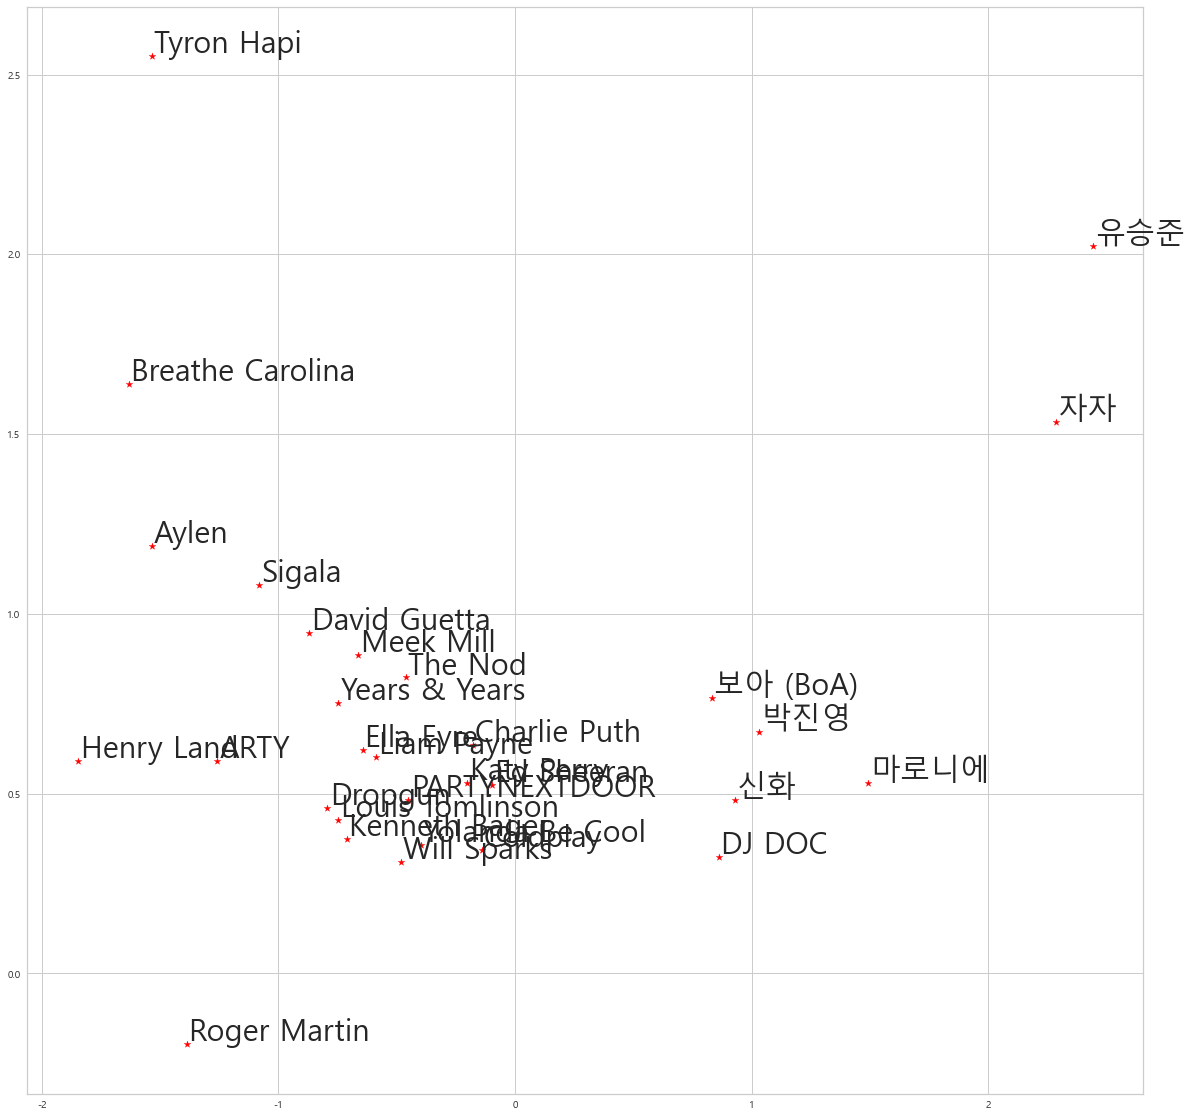

In [103]:
label = list(w2v_model.wv.vocab.keys())
print(label[0])
print(label[0], x_pca[0,:])

plt.figure(figsize=(20,20))
for i in range(30) :
    i = i + 127
    plt.scatter(x_pca[i,0], x_pca[i,1], marker='*', color='red')
    plt.text( x_pca[i,0]+0.01, x_pca[i, 1]+0.01, label[i], fontsize=30)

Phoenix
Phoenix [-0.5893439   0.67407054]


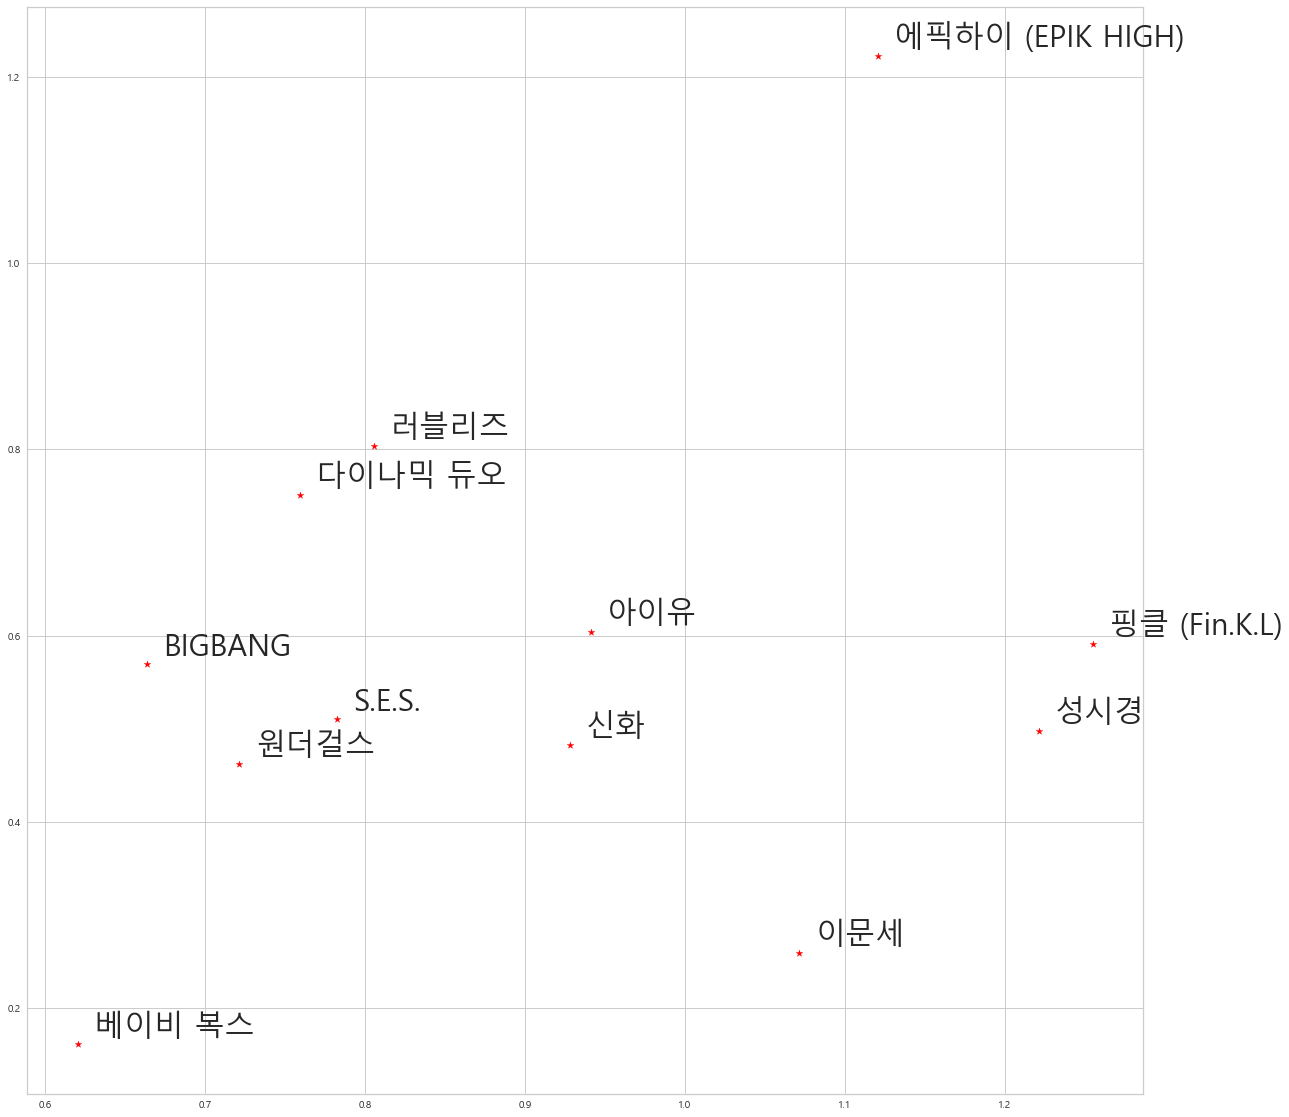

In [166]:
label = list(w2v_model.wv.vocab.keys())
print(label[0])
print(label[0], x_pca[0,:])

plt.figure(figsize=(20,20))
for i in [65, 127, 245, 269, 322, 484, 613, 785, 975, 107, 103,106] :
    plt.scatter(x_pca[i,0], x_pca[i,1], marker='*', color='red')
    plt.text( x_pca[i,0]+0.01, x_pca[i, 1]+0.01, label[i], fontsize=30)

---
## 군집화

## elbow method

In [51]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

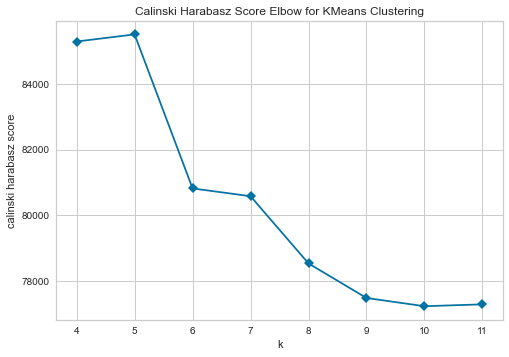

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [52]:
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(4,200), metric='calinski_harabasz', timings=False, locate_elbow=False
)

visualizer.fit(x_pca)        # Fit the data to the visualizer
visualizer.show() # 6개 군집화하는 것이 가장 좋게 나온다.

## Selecting the number of clusters with silhouette analysis on KMeans clustering

For n_clusters = 2 The average silhouette_score is : 0.3922252
For n_clusters = 3 The average silhouette_score is : 0.44891998
For n_clusters = 4 The average silhouette_score is : 0.35714713
For n_clusters = 5 The average silhouette_score is : 0.35720763
For n_clusters = 6 The average silhouette_score is : 0.3248337


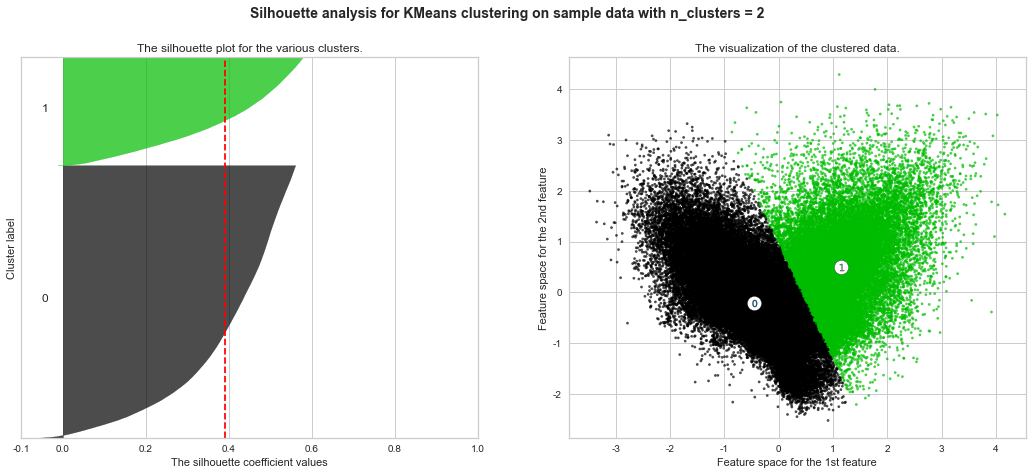

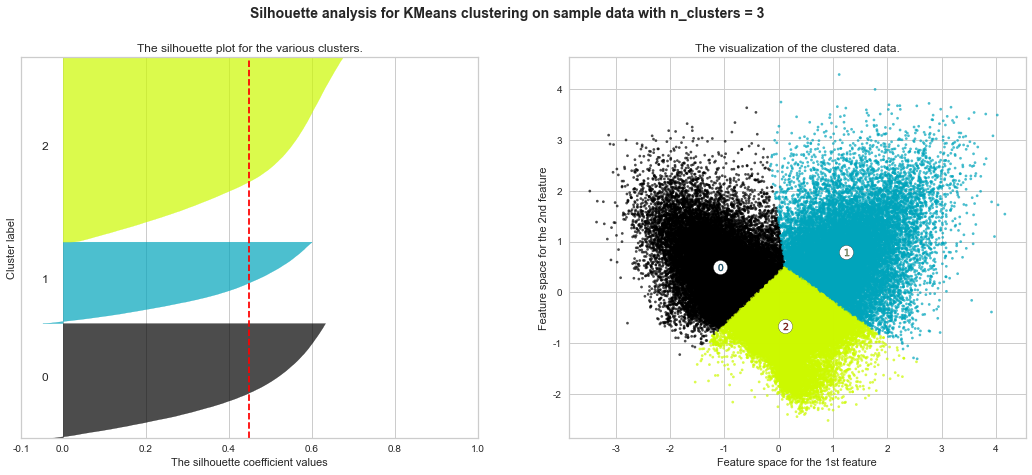

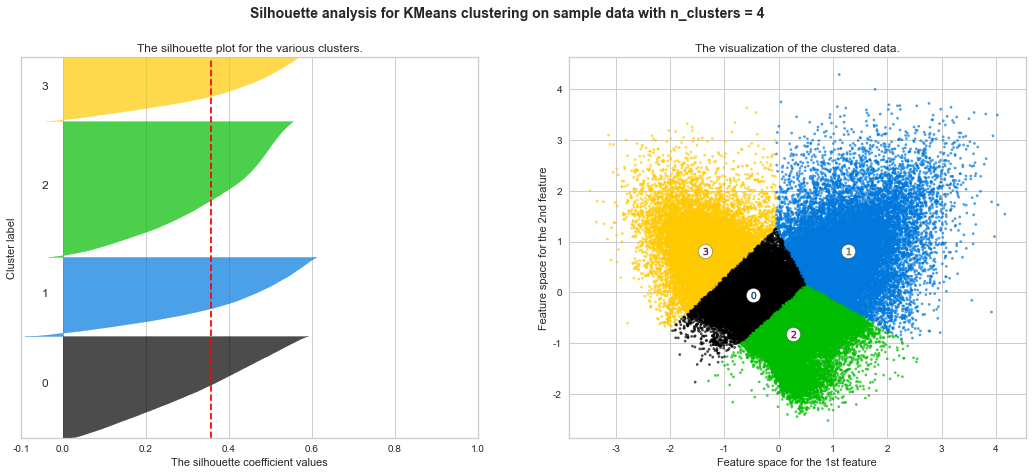

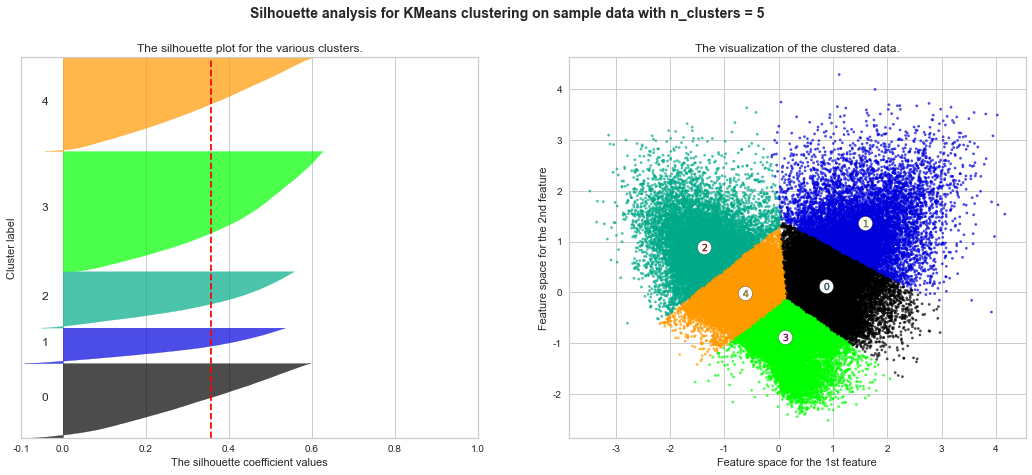

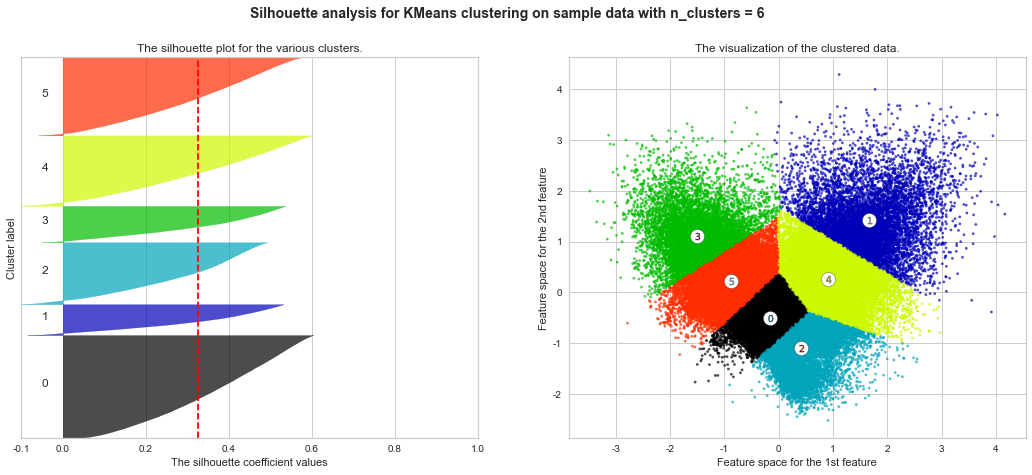

In [65]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x_pca) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(x_pca)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_pca, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_pca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        x_pca[:, 0],x_pca[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k")

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold")

plt.show()

In [163]:
cluster_labels

array([3, 8, 3, 3, 3, 3])

In [15]:
import gensim
from gensim.models import Word2Vec
import pandas as pd

In [16]:
df = pd.read_csv('data/artist_w2v_id.csv', encoding='utf-8-sig')

In [21]:
# cluster_labels

In [22]:
# df['label'] = cluster_labels

In [23]:
# df[df['label'] == 10].head(30).index

In [24]:
w2v_model = Word2Vec.load('data/artist_w2v.model')
w2v_model

from gensim.models import KeyedVectors 

In [25]:
label = list(w2v_model.wv.vocab.keys())
print(label[0])
print(label[0], tsne[0,:])

plt.figure(figsize=(10,10))
for i in [65, 127, 245, 269, 322, 484, 613, 785, 975, 107, 103,106,23304,172,179,197,243,255,253,252,279,260,366,379,439,441,457,466,464, 483] :
    plt.scatter(tsne[i,0], tsne[i,1], marker='*', color='red')
    plt.text( tsne[i,0]+0.01, tsne[i, 1]+0.03, label[i], fontsize=20)

Phoenix


NameError: name 'tsne' is not defined

In [ ]:
df_tsne = pd.DataFrame('data/df_tsne.csv',encoding='utf-8-sig')

In [ ]:
x = np.array([w2v_model.wv[v] for v in w2v_model.wv.vocab.keys()])
# print(x.shape)

# plt.plot(x[:,25], x[:,10], '*' )

x.shape

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2).fit_transform(x)

df_tsne=pd.DataFrame(tsne)

# df_tsne.to_csv('data/df_tsne.csv',index=False)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2).fit_transform(x)

tsne_df = pd.DataFrame({'x': tsne[:, 0], 'y':tsne[:, 1]})

plt.figure(figsize=(16, 10))
sns.scatterplot(
    x = 'x', y = 'y',
    hue = 'classes',
    palette = sns.color_palette("Set1", 10),
    data = tsne_df,
    legend = "full",
    alpha = 0.4
)

plt.title("tSNE")

plt.savefig('HW6/TSNE.png', bbox_inches='tight')  
plt.show()